In [1]:
import os

In [2]:
for i in ['data', 'model', 'img', 'result']:
    if not os.path.exists(i):
        os.makedirs(i)

# Download data

In [3]:
if not os.path.exists(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s5e3
    !unzip playground-series-s5e3.zip -d data
    !rm playground-series-s5e3.zip
    !kaggle datasets download subho117/rainfall-prediction-using-machine-learning
    !unzip rainfall-prediction-using-machine-learning.zip -d data
    !rm rainfall-prediction-using-machine-learning.zip

In [4]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
import scipy

from sklearn.pipeline import make_pipeline
import sgpp, dproc, sgutil

for i in [pl, pd, np, mpl, sns, lgb, sklearn, scipy]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

polars 1.12.0
pandas 2.2.3
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
sklearn 1.5.2
scipy 1.12.0


# Descriptive Analysis

In [5]:
p1 = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64}),
    sgpp.PandasCoverter(index_col = 'id')
)
df_train = p1.fit_transform(['data/train.csv'])

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int16  
 1   pressure       2190 non-null   float32
 2   maxtemp        2190 non-null   float32
 3   temparature    2190 non-null   float32
 4   mintemp        2190 non-null   float32
 5   dewpoint       2190 non-null   float32
 6   humidity       2190 non-null   float32
 7   cloud          2190 non-null   float32
 8   sunshine       2190 non-null   float32
 9   winddirection  2190 non-null   float32
 10  windspeed      2190 non-null   float32
 11  rainfall       2190 non-null   int8   
dtypes: float32(10), int16(1), int8(1)
memory usage: 109.1 KB


In [7]:
target = 'rainfall'
X = [
    'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
    'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'
]
sc = sgutil.SGCache('img', 'result')

In [8]:
pd.concat([
    df_train[X].describe(),
    df_train[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602051,26.365799,23.953056,22.170092,20.454567,82.036530,75.721916,3.744429,104.863152,21.804703
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800653,18.026497,3.626327,80.002411,9.898659
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000
25%,89.000000,1008.599976,21.299999,19.299999,17.700001,16.799999,77.000000,69.000000,0.400000,40.000000,14.125000
50%,178.500000,1013.000000,27.799999,25.500000,23.849999,22.150001,82.000000,83.000000,2.400000,70.000000,20.500000
75%,270.000000,1017.774994,31.200001,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000
max,365.000000,1034.599976,36.000000,31.500000,29.799999,26.700001,98.000000,100.000000,12.100000,300.000000,59.500000
nunique,365.000000,236.000000,219.000000,198.000000,199.000000,218.000000,49.000000,78.000000,120.000000,35.000000,223.000000


In [9]:
df_test = p1.transform(['data/test.csv'])

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int16  
 1   pressure       730 non-null    float32
 2   maxtemp        730 non-null    float32
 3   temparature    730 non-null    float32
 4   mintemp        730 non-null    float32
 5   dewpoint       730 non-null    float32
 6   humidity       730 non-null    float32
 7   cloud          730 non-null    float32
 8   sunshine       730 non-null    float32
 9   winddirection  729 non-null    float32
 10  windspeed      730 non-null    float32
dtypes: float32(10), int16(1)
memory usage: 35.6 KB


In [11]:
pd.concat([
    df_test[X].describe(),
    df_test[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,183.000000,1013.503052,26.372467,23.963287,22.110273,20.460138,82.669861,76.360275,3.664384,103.923180,22.484247
std,105.438271,5.505871,5.672521,5.278099,5.170743,5.391169,7.818714,17.934122,3.639272,81.695457,9.954779
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,92.000000,1008.725006,21.600000,19.824999,17.824999,16.799999,77.250000,69.000000,0.325000,40.000000,14.500000
50%,183.000000,1012.700012,27.799999,25.650001,23.900000,22.299999,82.000000,83.000000,2.200000,70.000000,21.299999
75%,274.000000,1017.599976,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,365.000000,1032.199951,35.799999,31.799999,29.100000,26.700001,98.000000,100.000000,11.800000,300.000000,59.500000
nunique,365.000000,185.000000,182.000000,175.000000,171.000000,172.000000,42.000000,69.000000,110.000000,29.000000,205.000000


In [12]:
df_org = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64, 'day': pl.Int16, 'rainfall': pl.String}),
    sgpp.ExprProcessor({
        'rainfall': pl.col('rainfall').replace({'yes': 1, 'no': 0}).cast(pl.Int8)
    }),
    sgpp.PandasCoverter(index_col = 'id'), 
).fit_transform(['data/Rainfall.csv']).rename(
    columns = lambda x: x.strip()
)

In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int16  
 1   pressure       366 non-null    float32
 2   maxtemp        366 non-null    float32
 3   temparature    366 non-null    float32
 4   mintemp        366 non-null    float32
 5   dewpoint       366 non-null    float32
 6   humidity       366 non-null    int8   
 7   cloud          366 non-null    int8   
 8   rainfall       366 non-null    int8   
 9   sunshine       366 non-null    float32
 10  winddirection  365 non-null    float32
 11  windspeed      365 non-null    float32
dtypes: float32(8), int16(1), int8(3)
memory usage: 13.4 KB


In [14]:
pd.concat([
    df_org[X].describe(),
    df_org[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,365.000000,365.000000
mean,15.756831,1013.742554,26.191257,23.747269,21.894535,19.989071,80.177596,71.128415,4.419399,101.506851,21.536985
std,8.823592,6.414776,5.978343,5.632813,5.594152,5.997021,10.062470,21.798012,3.934398,81.723724,10.069712
min,1.000000,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,10.000000,4.400000
25%,8.000000,1008.500000,21.200001,18.824999,17.125000,16.125000,75.000000,58.000000,0.500000,40.000000,13.700000
50%,16.000000,1013.000000,27.750000,25.450000,23.700001,21.950000,80.500000,80.000000,3.500000,70.000000,20.500000
75%,23.000000,1018.099976,31.200001,28.600000,26.575000,25.000000,87.000000,88.000000,8.200000,190.000000,27.900000
max,31.000000,1034.599976,36.299999,32.400002,30.000000,26.700001,98.000000,100.000000,12.100000,350.000000,59.500000
nunique,31.000000,188.000000,174.000000,158.000000,157.000000,158.000000,49.000000,79.000000,104.000000,31.000000,223.000000


In [15]:
df_org.loc[df_org[X].isna().any(axis=1)]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
160,9,1005.700012,31.700001,28.200001,26.6,25.700001,86,79,1,6.5,NaN,NaN


# Train / Test / Org Difference

## Train vs Test 

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold
import lightgbm as lgb

In [17]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X].assign(is_train = True),
    df_test[X].assign(is_train = False)
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.05853248, 0.01734376, 0.01722622, 0.01733661, 0.01739001]),
 'score_time': array([0.00305414, 0.00197101, 0.00203609, 0.00192404, 0.00195718]),
 'test_score': array([0.45865391, 0.49407331, 0.48434666, 0.46880278, 0.49080503]),
 'train_score': array([0.96311554, 0.96476092, 0.96260145, 0.96829651, 0.97169282])}

Train과 Test Set의 구분이 어렵습니다.

## Train vs Org

In [18]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X + [target]].assign(is_train = True),
    df_org[X + [target]].assign(is_train = False)
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X + [target]], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.01933622, 0.01753521, 0.01746678, 0.01841903, 0.01688457]),
 'score_time': array([0.00206661, 0.00196862, 0.00197315, 0.00202942, 0.00195646]),
 'test_score': array([0.9922251 , 0.98570714, 0.9847376 , 0.9811722 , 0.99218115]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [19]:
clf_lgb = lgb.LGBMClassifier(verbose = 0, num_leaves = 15).fit(df[X + [target]], df['is_train'])

In [20]:
pd.Series(
    clf_lgb.feature_importances_, index = X + [target]
).sort_values(ascending = False).iloc[:5]

day            278
windspeed      201
dewpoint       159
maxtemp        129
temparature    124
dtype: int32

In [21]:
df_train['day'].value_counts()

day
91     7
144    7
267    7
140    7
111    7
      ..
157    5
286    5
38     5
336    5
365    5
Name: count, Length: 365, dtype: int64

In [22]:
X_ = [i for i in X + [target] if i != 'day']

cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X_], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.01899004, 0.01778316, 0.01746631, 0.01755118, 0.01685143]),
 'score_time': array([0.00325131, 0.00197053, 0.00193381, 0.00196218, 0.00191116]),
 'test_score': array([0.51604344, 0.53480953, 0.57315319, 0.50134484, 0.5511353 ]),
 'train_score': array([0.9829549 , 0.98471664, 0.98433969, 0.9833345 , 0.98481891])}

원본 데이터와 학습 데이터는 구분이 명확히 되지만,
day 속성을 빼면 구분이 어렵습니다.

그리고, 원본 데이터는 day는 일자상의 day이고 Playground는 dayofyear를 나타냅니다.

**TODO**: 데이터가 적습니다. 원본 데이터의 day를 Playground 셋에 맞추어 사용할 수 있을지 살펴봅니다.

## Target Distribution

In [23]:
df_train[target].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

In [24]:
df_org[target].value_counts(normalize=True)

rainfall
1    0.680328
0    0.319672
Name: proportion, dtype: float64

## Features

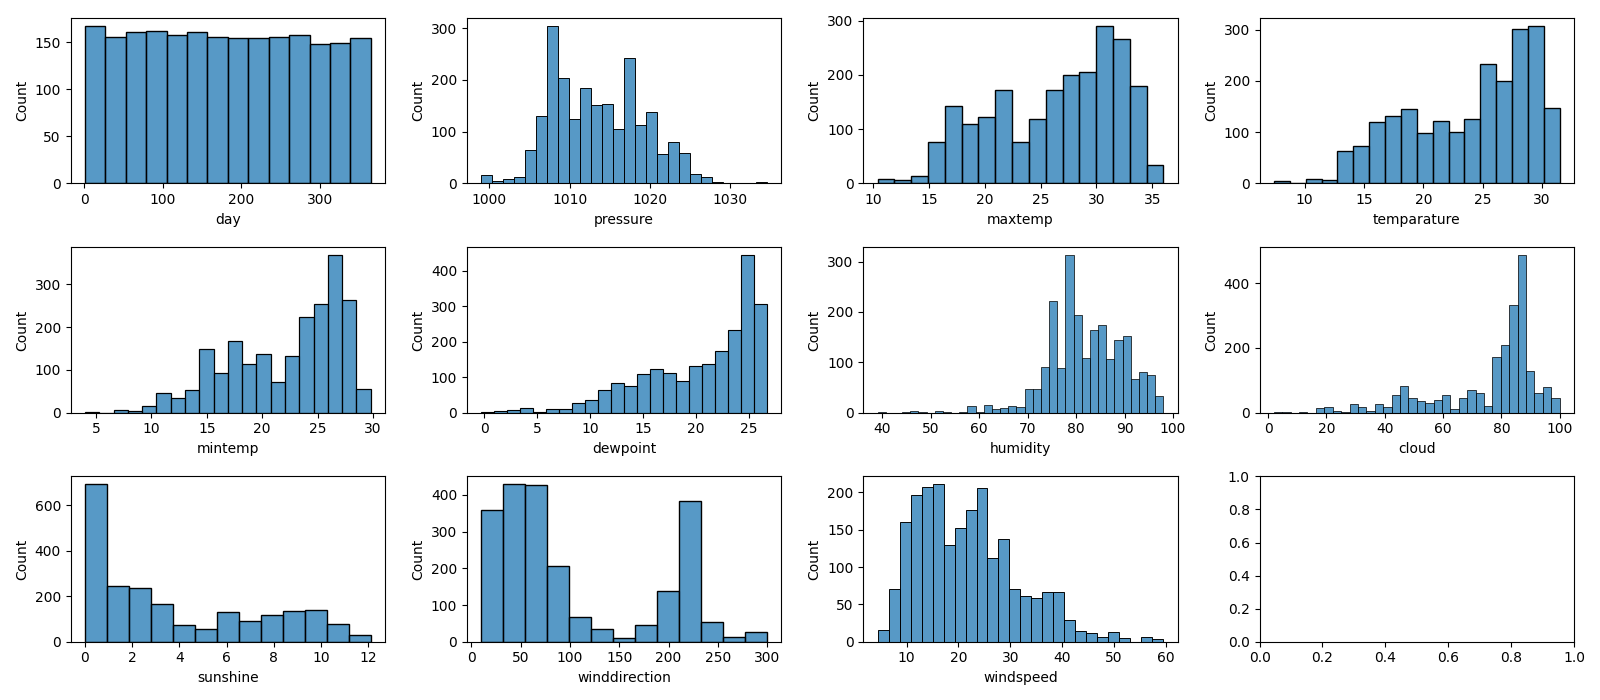

In [25]:
sc.cache_fig(
    'dist_features', lambda x: [sns.histplot(df_train, x=i, ax=ax) for i, ax in zip(X, x)] , 3, 4, (16, 7), redraw = False
)

# Exploratory Data Analysis

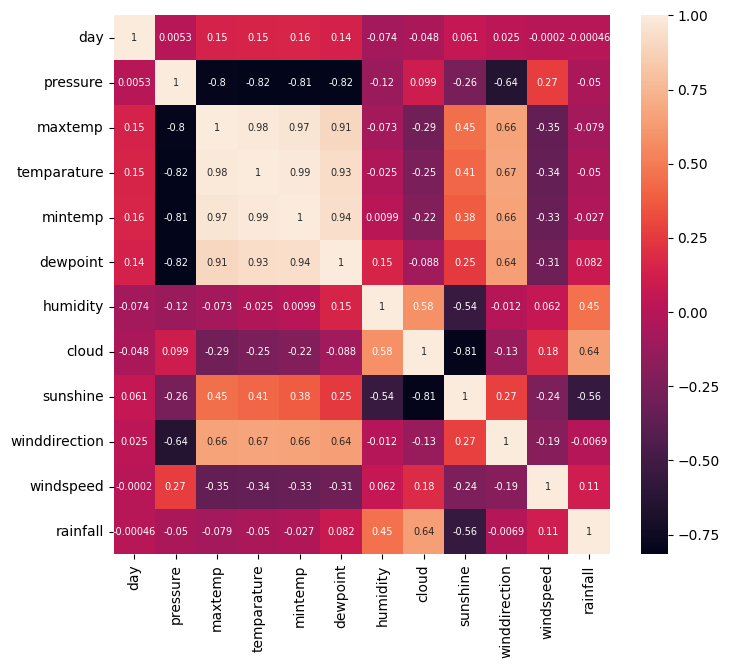

In [26]:
plt.figure(figsize = (8, 7))
sns.heatmap(
    df_train[X + [target]].corr(),
    annot = True, annot_kws = {'size': 7}
)
plt.show()

## 속성들의 공선성을 확인해봅니다.

In [27]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [28]:
coef_list = list()
r2_list = list()
intercept_list = list()
reg_lr = LinearRegression()
for i in X:
    X_lr = [j for j in X if j != i]
    reg_lr.fit(df_train[X_lr], df_train[i])
    coef_list.append(pd.Series(reg_lr.coef_, index = X_lr, name = i))
    r2_list.append(
        r2_score(df_train[i], reg_lr.predict(df_train[X_lr]))
    )
    intercept_list.append(reg_lr.intercept_)

df_lr = pd.DataFrame(coef_list).join(
    pd.Series(intercept_list, index = X, name = 'itercept')
).join(
    pd.Series(r2_list, index = X, name = 'r2')
)
df_lr

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,day,itercept,r2
day,7.031203,-1.291124,1.299525,9.599524,2.247223,-1.240343,0.190111,-0.751843,-0.113912,0.644256,NaN,-7114.697754,0.093398
pressure,NaN,-0.128567,-0.334719,-0.046389,-0.302663,-0.057440,-0.011099,-0.040490,-0.010252,-0.005711,0.006180,1038.020508,0.724258
maxtemp,-0.014075,NaN,1.145876,-0.124231,-0.000971,-0.019503,-0.002179,0.042681,0.000585,-0.007918,-0.000124,17.697680,0.969803
temparature,-0.012443,0.389134,NaN,0.529731,0.052581,-0.003636,0.000906,0.014618,0.000242,-0.000603,0.000042,13.640833,0.987979
mintemp,-0.002960,-0.072420,0.909331,NaN,0.128894,0.004071,-0.002668,-0.016017,0.000226,0.003046,0.000538,2.403200,0.978011
dewpoint,-0.080531,-0.002361,0.376321,0.537400,NaN,0.071881,0.008913,-0.067728,0.000940,-0.007802,0.000526,74.873734,0.916097
humidity,-0.210685,-0.653447,-0.358765,0.233998,0.990899,NaN,0.129894,-0.498410,-0.006714,-0.009563,-0.003999,289.616241,0.468405
cloud,-0.128244,-0.229973,0.281410,-0.483143,0.387030,0.409180,NaN,-3.526097,0.012509,0.030561,0.001931,185.137680,0.686424
sunshine,-0.016939,0.163107,0.164501,-0.105001,-0.106490,-0.056848,-0.127672,NaN,0.001726,-0.010281,-0.000276,31.603756,0.719434
winddirection,-3.833260,1.998021,2.437246,1.325418,1.321001,-0.684430,0.404788,1.542359,NaN,0.348816,-0.037434,3841.650635,0.484802


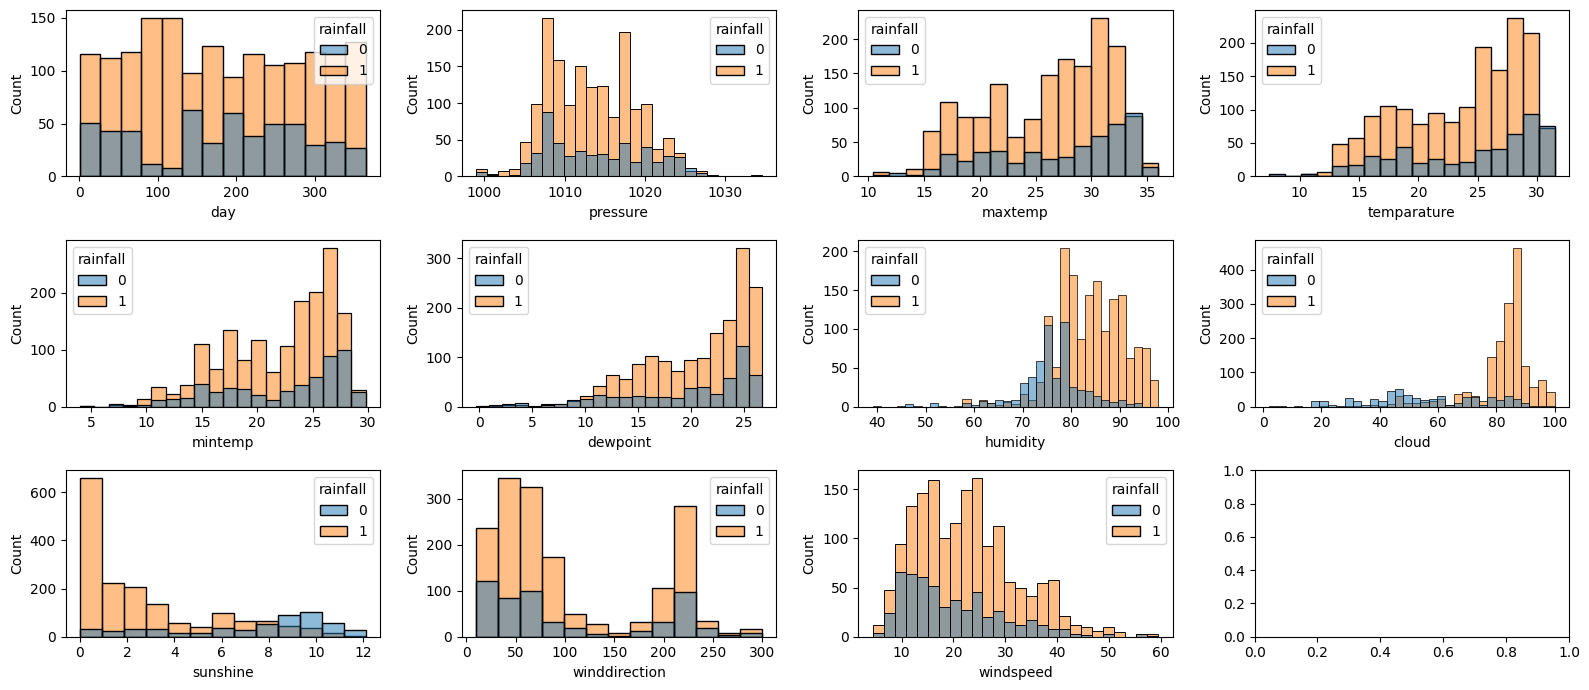

In [29]:
sc.cache_fig(
    'dist_features_tgt', lambda x: [sns.histplot(df_train, x=i, ax=ax, hue=target) for i, ax in zip(X, x)] , 3, 4, (16, 7), redraw = False
)

## Relation with day

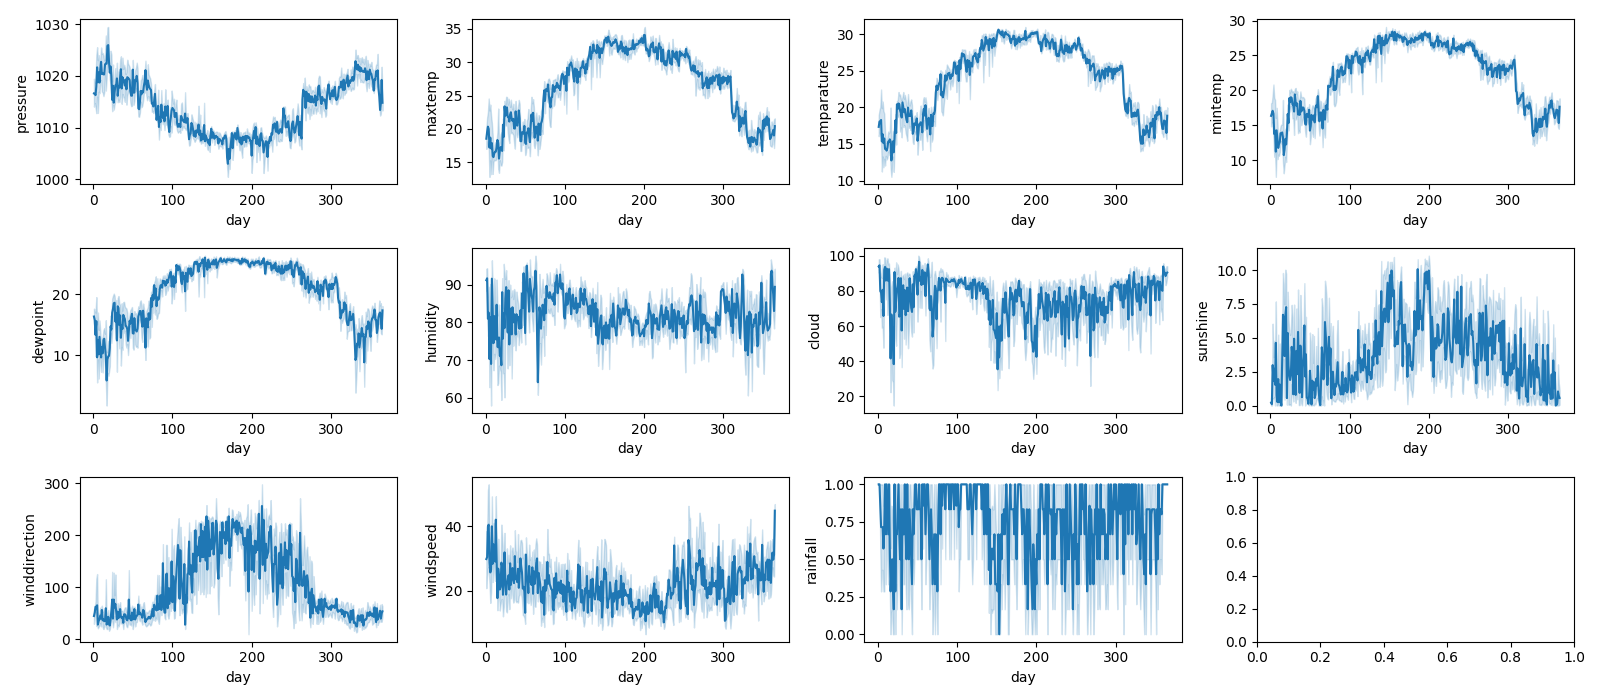

In [30]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_day', lambda x: [sns.lineplot(df_train, x='day', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

In [31]:
df_train['day'].value_counts().value_counts()

count
6    297
7     34
5     34
Name: count, dtype: int64

In [32]:
df_test['day'].value_counts().value_counts()

count
2    365
Name: count, dtype: int64

In [33]:
df_train['day'].value_counts().pipe(
    lambda x: x.loc[x == 5]
).sort_index().pipe(
    lambda x: pd.concat([x, x.index.to_series().pipe(lambda x: x - x.shift(1)).rename('delta')], axis=1)
)

,count,delta
day,,
38,5,NaN
157,5,119.0
190,5,33.0
196,5,6.0
218,5,22.0
224,5,6.0
252,5,28.0
258,5,6.0
273,5,15.0


In [34]:
df_train['day'].value_counts().pipe(
    lambda x: x.loc[x == 7]
).sort_index().pipe(
    lambda x: pd.concat([x, x.index.to_series().pipe(lambda x: x - x.shift(1)).rename('delta')], axis=1)
)

,count,delta
day,,
3,7,NaN
4,7,1.0
5,7,1.0
6,7,1.0
7,7,1.0
8,7,1.0
9,7,1.0
15,7,6.0
16,7,1.0


학습데이터의 day의 빈도가 5인것이 34개 7인것이 34개 동수가 존재하며 나머지는 6개라는 점에서 day에는 노이즈가 있을 가능성이 높습니다.

[Binary Prediction with a Rainfall Dataset](https://www.kaggle.com/competitions/playground-series-s5e3/discussion/565634) 에서 이와 관련된 현상이 나와 있습니다.

In [35]:
df_train['expected_day'] = (df_train.index % 365) + 1
df_train.query('expected_day != day')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,expected_day
id,,,,,,,,,,,,,
1037,3,1015.200012,25.000000,23.900000,23.600000,19.900000,76.0,61.0,8.8,90.0,14.100000,0,308
1132,265,1020.599976,18.400000,17.100000,16.900000,15.000000,75.0,86.0,0.0,40.0,24.900000,1,38
1210,80,1011.500000,29.799999,26.799999,25.100000,23.200001,87.0,81.0,2.5,20.0,12.700000,1,116
1251,236,1005.000000,35.299999,31.000000,26.400000,26.400000,74.0,49.0,10.8,230.0,28.600000,1,157
1284,4,1007.900024,33.000000,30.100000,27.799999,25.100000,78.0,67.0,5.7,220.0,12.500000,1,190
1290,16,1008.400024,32.299999,29.000000,26.500000,24.400000,79.0,40.0,11.2,220.0,12.400000,0,196
1312,5,1005.700012,31.700001,28.500000,27.299999,24.299999,76.0,49.0,7.2,240.0,15.100000,1,218
1318,6,1002.500000,32.000000,28.900000,26.400000,24.900000,84.0,73.0,8.4,20.0,9.500000,1,224
1346,151,1008.400024,32.799999,29.400000,27.000000,24.299999,74.0,27.0,10.6,220.0,12.400000,0,252


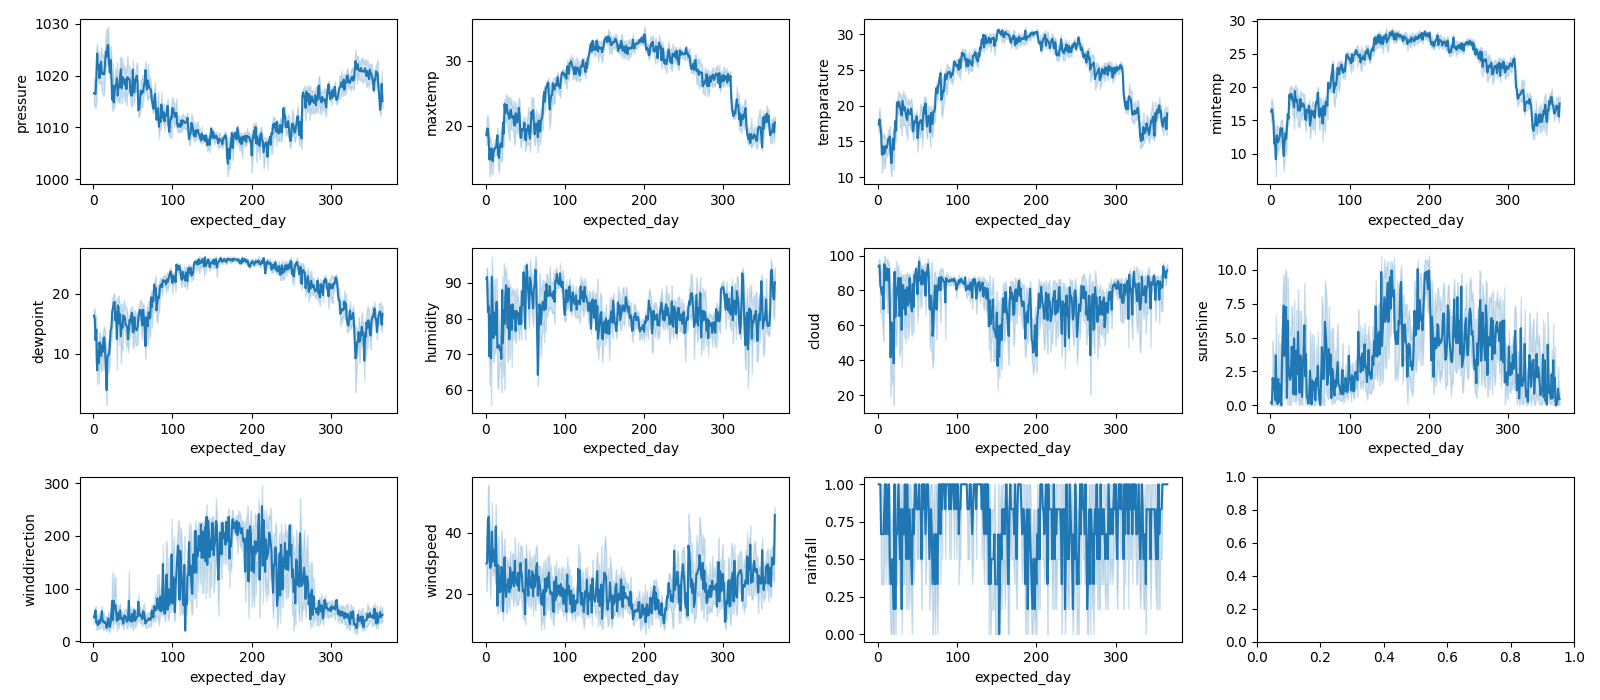

In [36]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_expected_day', lambda x: [sns.lineplot(df_train, x='expected_day', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

id가 시간 순서에 따르는 것이 가능성이 높아 보입니다. 

**TODO** day와 expected_day 사용했을 때와의 성능차이 비교

원본 데이터도 시간순서대로 배치가 되었는지 살펴봅니다.

In [37]:
(df_org['day'] - df_org['day'].shift()).value_counts()

day
 1.0     354
-30.0      6
-29.0      4
-28.0      1
Name: count, dtype: int64

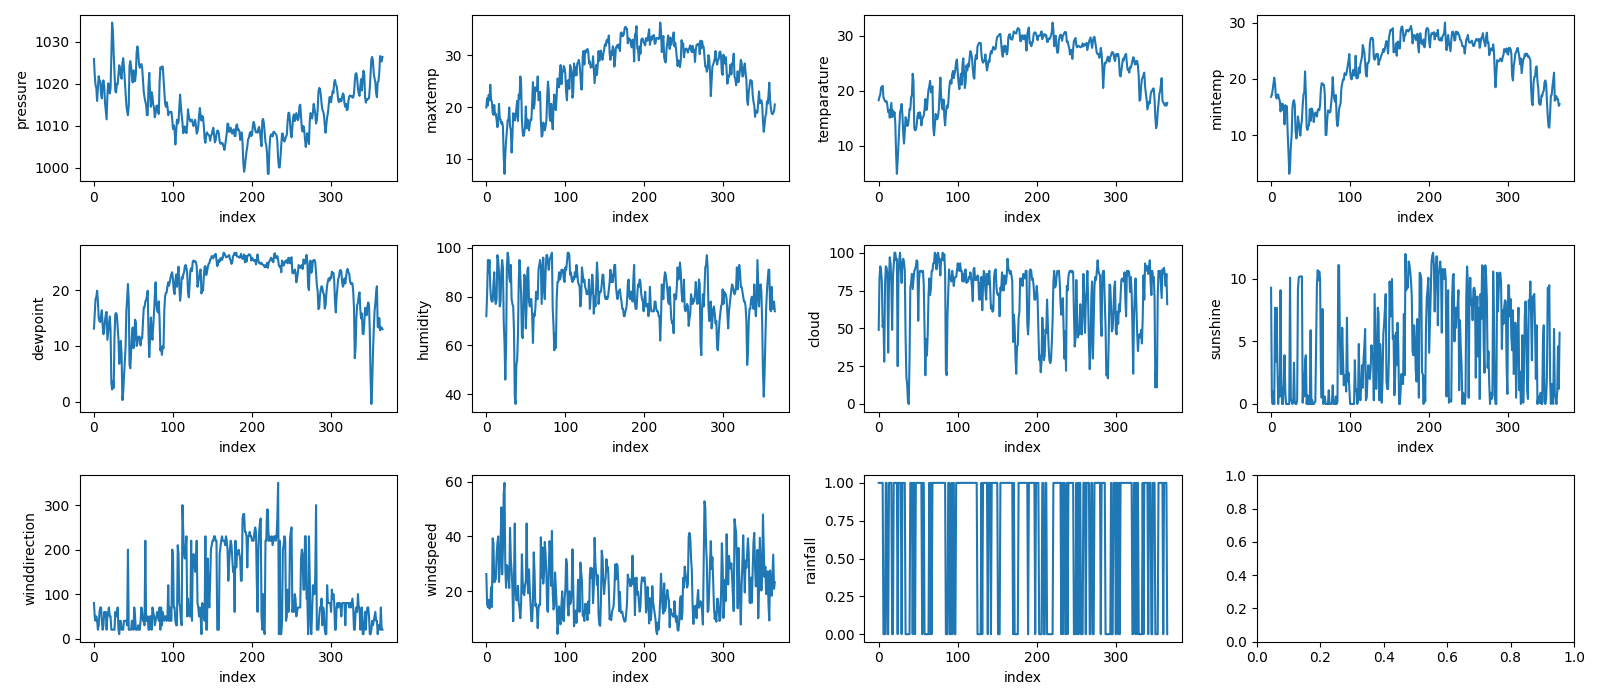

In [38]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_day_org', lambda x: [sns.lineplot(df_org.reset_index(), x='index', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

## Train과 Org 재비교

In [39]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X + [target]].assign(is_train = True),
    df_org[X + [target]].assign(is_train = False, day = lambda x: x.index + 1).dropna().query('day < 366')
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X + [target]], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.02052712, 0.01784468, 0.01774549, 0.01761723, 0.01816273]),
 'score_time': array([0.00213361, 0.00196552, 0.0019443 , 0.00194764, 0.00194502]),
 'test_score': array([0.77459811, 0.73515982, 0.78304247, 0.80724964, 0.77356038]),
 'train_score': array([0.99573977, 0.99641843, 0.9971167 , 0.99574173, 0.9965773 ])}

org의 day를 일자순서로 정렬 데이터로 가정을 하고 day를 365일 단위로 변환을 했을 때에도 어느 정도 kaggle 데이터와 원본데이터에 차이를 보입니다.

In [40]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_test[X].assign(is_train = True),
    df_org[X].assign(is_train = False, day = lambda x: x.index + 1).dropna().query('day < 366')
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.0153389 , 0.01524258, 0.01509571, 0.01514721, 0.01519084]),
 'score_time': array([0.00185466, 0.00179505, 0.00177646, 0.00176597, 0.00198221]),
 'test_score': array([0.73662976, 0.76599737, 0.79968099, 0.69797335, 0.7613204 ]),
 'train_score': array([0.99921739, 0.99792285, 0.99804053, 0.99923504, 0.99907933])}

test하고도 차이가 train 와 차이가 비슷한 정도로 보입니다.

## sin(expected_day / 365)

In [41]:
df_train['sin_ed'] = np.sin(df_train['expected_day'] / 365 * np.pi)

In [42]:
coef_list = list()
r2_list = list()
intercept_list = list()
reg_lr = LinearRegression()
X2 = [i for i in X if i not in ['maxtemp', 'mintemp', 'dewpoint']]+ ['sin_ed']
for i in X2:
    X_lr = [j for j in X2 if j != i]
    reg_lr.fit(df_train[X_lr], df_train[i])
    coef_list.append(pd.Series(reg_lr.coef_, index = X_lr, name = i))
    r2_list.append(
        r2_score(df_train[i], reg_lr.predict(df_train[X_lr]))
    )
    intercept_list.append(reg_lr.intercept_)

df_lr = pd.DataFrame(coef_list).join(
    pd.Series(intercept_list, index = X2, name = 'itercept')
).join(
    pd.Series(r2_list, index = X2, name = 'r2')
)
df_lr

,pressure,temparature,humidity,cloud,sunshine,winddirection,windspeed,sin_ed,day,itercept,r2
day,4.403610,17.914467,-1.055717,0.186095,-1.171647,-0.051114,0.322326,-183.659296,NaN,-4520.511429,0.132533
pressure,NaN,-0.491209,-0.083854,-0.012742,-0.016578,-0.008378,-0.013747,-6.364362,0.003872,1037.807283,0.736048
temparature,-0.219810,NaN,0.020012,-0.002516,0.138028,0.004947,-0.012721,10.285686,0.007049,236.727446,0.861488
humidity,-0.354876,0.189263,NaN,0.153387,-0.682894,-0.005671,-0.015659,-2.866559,-0.003929,431.616142,0.412863
cloud,-0.154470,-0.068161,0.439373,NaN,-3.570117,0.012735,0.028649,-0.083442,0.001984,208.984952,0.685064
sunshine,-0.007391,0.137512,-0.071937,-0.131292,NaN,0.001668,-0.011333,0.088993,-0.000459,23.883234,0.713801
winddirection,-3.221551,4.251015,-0.515246,0.403942,1.438849,NaN,0.433295,64.091395,-0.017282,3227.564133,0.492830
windspeed,-0.135567,-0.280347,-0.036489,0.023306,-0.250706,0.011113,NaN,-9.809362,0.002795,172.675069,0.150322
sin_ed,-0.011042,0.039879,-0.001175,-0.000012,0.000346,0.000289,-0.001726,NaN,-0.000280,11.027259,0.845441


## sin, cos to winddirection

In [43]:
df_train['sin_wd'] = np.sin(df_train['winddirection'] / 180 * np.pi) * df_train['windspeed']
df_train['cos_wd'] = np.cos(df_train['winddirection'] / 180 * np.pi) * df_train['windspeed']

In [44]:
coef_list = list()
r2_list = list()
intercept_list = list()
reg_lr = LinearRegression()
X2 = [i for i in X if i not in ['maxtemp', 'mintemp', 'dewpoint']]+ ['sin_ed', 'sin_wd', 'cos_wd']
for i in X2:
    X_lr = [j for j in X2 if j != i]
    reg_lr.fit(df_train[X_lr], df_train[i])
    coef_list.append(pd.Series(reg_lr.coef_, index = X_lr, name = i))
    r2_list.append(
        r2_score(df_train[i], reg_lr.predict(df_train[X_lr]))
    )
    intercept_list.append(reg_lr.intercept_)

df_lr = pd.DataFrame(coef_list).join(
    pd.Series(intercept_list, index = X2, name = 'itercept')
).join(
    pd.Series(r2_list, index = X2, name = 'r2')
)
df_lr

,pressure,temparature,humidity,cloud,sunshine,winddirection,windspeed,sin_ed,sin_wd,cos_wd,day,itercept,r2
day,4.360390,17.770421,-1.099257,0.183227,-1.170772,-0.017058,0.202651,-182.846222,0.258368,-0.016452,NaN,-4473.053149,0.133094
pressure,NaN,-0.512556,-0.086580,-0.012959,-0.011522,-0.010278,-0.014116,-6.399673,0.012930,-0.030013,0.003804,1038.806288,0.738273
temparature,-0.223519,NaN,0.014581,-0.002868,0.139667,0.002541,-0.013898,9.831071,0.018669,-0.038524,0.006761,241.586118,0.866155
humidity,-0.365160,0.141024,NaN,0.150761,-0.671371,0.000284,-0.041301,-2.746490,0.064128,-0.024403,-0.004045,442.798388,0.419807
cloud,-0.158403,-0.080403,0.436939,NaN,-3.567772,0.012964,0.025298,-0.095423,0.011305,-0.010718,0.001954,213.470267,0.685122
sunshine,-0.005171,0.143747,-0.071446,-0.131003,NaN,0.003013,-0.013430,0.133571,0.000377,0.010293,-0.000458,21.249178,0.714298
winddirection,-1.586547,0.899589,0.010394,0.163715,1.036309,NaN,1.585948,8.621350,-1.933259,-2.637451,-0.002297,1662.711978,0.798106
windspeed,-0.112421,-0.253819,-0.077990,0.016483,-0.238303,0.081823,NaN,-5.992911,0.339664,0.202461,0.001408,139.091499,0.319604
sin_ed,-0.011135,0.039224,-0.001133,-0.000014,0.000518,0.000097,-0.001309,NaN,-0.000460,-0.001003,-0.000278,11.152046,0.846307
sin_wd,0.143495,0.475106,0.168742,0.010264,0.009314,-0.138987,0.473311,-2.932450,NaN,0.005636,0.002502,-157.400327,0.628823


## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd']
ct = ColumnTransformer([
    ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
    ('pt', 'passthrough', ['sin_ed'])
])
clf_lr = make_pipeline(
    ct,
    LogisticRegression(solver='lbfgs')
)
clf_lr.fit(df_train[X_lr], df_train[target])
prd = clf_lr.predict_proba(df_train[X_lr])[:, 1]
roc_auc_score(
    df_train[target], prd
)

0.8976442199775532

In [46]:
pd.Series(clf_lr[1].coef_[0], index = X_lr).sort_values()

sunshine        -0.560697
mintemp         -0.337058
sin_ed          -0.260818
pressure        -0.243936
winddirection   -0.166651
sin_wd          -0.155680
temparature     -0.154916
cos_wd           0.008638
day              0.055984
maxtemp          0.103036
windspeed        0.166799
humidity         0.318087
dewpoint         0.694589
cloud            1.144271
dtype: float64

In [47]:
result = cross_validate(
    clf_lr, df_train[X_lr], df_train[target], scoring = 'roc_auc', cv = skf, return_train_score = True
)
np.mean(result['test_score']), np.mean(result['train_score'])

(0.8927384960718294, 0.8981456930415262)

In [48]:
from scipy.stats import spearmanr
y_true = df_train[target]
ce = -(y_true * np.log(prd) + (1 - y_true) * np.log(1 - prd))
pd.Series(ce).pipe(
    lambda x: pd.concat([x, x.shift(365).rename()], axis=1).dropna()
).pipe(
    lambda x: spearmanr(x.iloc[:, 0], x.iloc[:, 1])
)

SignificanceResult(statistic=0.16190227712975522, pvalue=3.459231894275837e-12)

In [49]:
df_ce = pd.concat([
    pd.Series(ce, index = df_train.index, name = 'ce'),
    df_train['expected_day'],
    pd.Series(prd, index = df_train.index, name = 'prd')
], axis=1)

In [50]:
df_ce_stat = df_ce.groupby('expected_day')['ce'].agg(['mean', 'std']).sort_values('mean', ascending = False)
df_ce_stat.iloc[:25]

,mean,std
expected_day,,
75,1.527022,1.350789
72,1.438745,1.345820
302,1.273916,1.242809
353,1.242873,1.332649
102,1.158937,1.680226
321,1.145059,0.776628
172,1.090812,1.321886
248,1.011898,1.122483
50,1.003978,1.313382


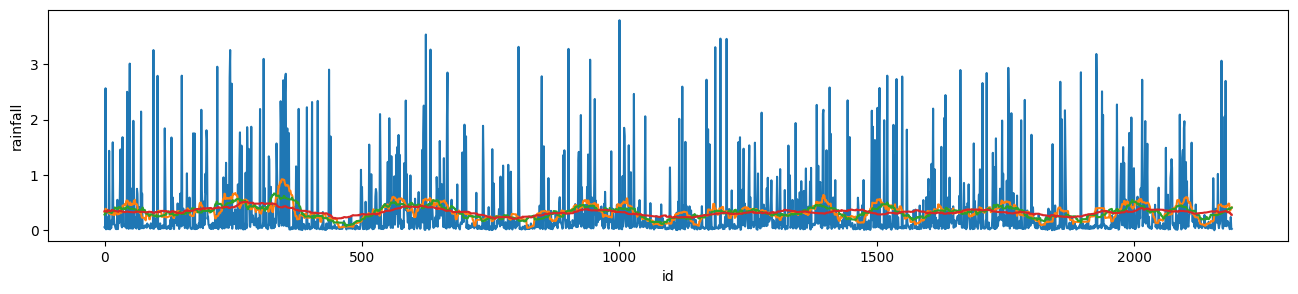

In [51]:
plt.figure(figsize=(16, 3))
sns.lineplot(ce)
sns.lineplot(df_ce['ce'].rolling(30, min_periods = 1, center = True).mean())
sns.lineplot(df_ce['ce'].rolling(60, min_periods = 1, center = True).mean())
sns.lineplot(df_ce['ce'].rolling(180, min_periods = 1, center = True).mean())
plt.show()

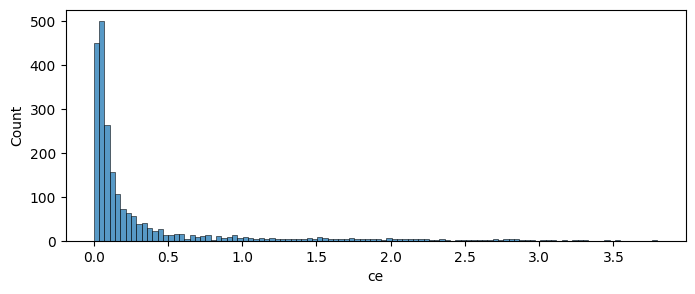

In [52]:
plt.figure(figsize = (8, 3))
sns.histplot(df_ce['ce'])
plt.show()

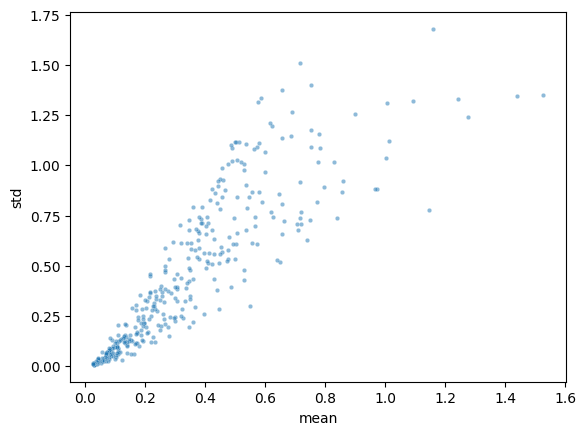

In [53]:
sns.scatterplot(df_ce_stat, x = 'mean', y = 'std', s = 10, alpha = 0.5)
plt.show()

## Periodicity & Trend

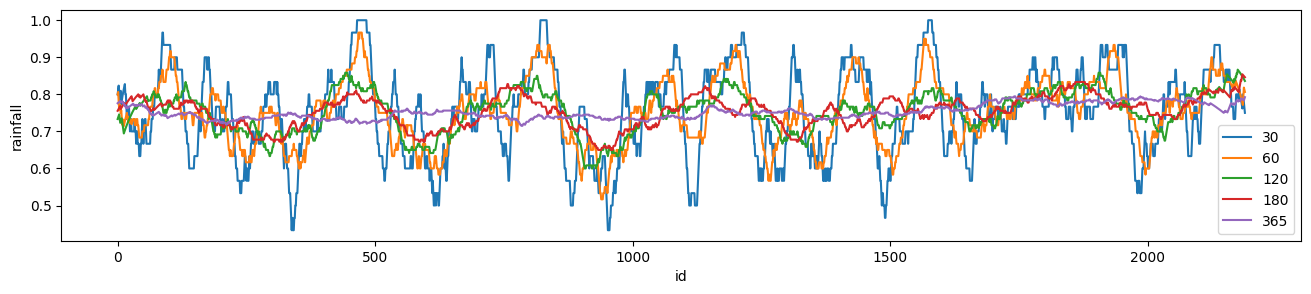

In [54]:
plt.figure(figsize = (16, 3))
for i in [30, 60, 120, 180, 365]:
    sns.lineplot(
        df_train[target].rolling(i, min_periods = 1, center = True).mean(), label = i
    )
plt.show()

In [55]:
from scipy.stats import pearsonr
df_train[target].rolling(365, min_periods = 365, center = False).mean().dropna().pipe(
    lambda x: pearsonr(x.index, x.values)
)

PearsonRResult(statistic=0.7606178613277874, pvalue=0.0)

Railfall을 365일 이동 평균으로 구한 확률로 보아 증가 추세에 있음을 확인할 수 있습니다.

In [56]:
pd.DataFrame([df_train[i].rolling(365, min_periods = 365, center = False).mean().dropna().pipe(
    lambda x: pd.Series(pearsonr(x.index, x.values), index = ['r', 'pvalue'])
) for i in X[1:]], index = X[1:])

,r,pvalue
pressure,-0.247867,5.752227e-27
maxtemp,-0.148861,1.633131e-10
temparature,0.087833,1.713226e-04
mintemp,0.297077,1.587291e-38
dewpoint,-0.124159,1.023452e-07
humidity,-0.435224,2.840627e-85
cloud,0.290255,8.860066e-37
sunshine,-0.130843,2.006160e-08
winddirection,-0.090585,1.061172e-04
windspeed,0.208272,2.416253e-19


In [57]:
df_ce['prd'].rolling(365, min_periods = 365, center = False).mean().dropna().pipe(
    lambda x: pearsonr(x.index, x.values)
)

PearsonRResult(statistic=0.23788561835440059, pvalue=6.578647574381437e-25)

In [58]:
pd.DataFrame([df_test[i].rolling(365, min_periods = 365, center = False).mean().dropna().pipe(
    lambda x: pd.Series(pearsonr(x.index, x.values), index = ['r', 'pvalue'])
) for i in X[1:]], index = X[1:])

,r,pvalue
pressure,-0.902322,4.349824e-135
maxtemp,-0.084133,1.080756e-01
temparature,0.356136,2.194788e-12
mintemp,0.519100,1.217292e-26
dewpoint,0.737694,4.472396e-64
humidity,-0.426940,1.201673e-17
cloud,-0.841071,3.610113e-99
sunshine,0.846472,1.130937e-101
winddirection,-0.671018,2.307496e-21
windspeed,0.357795,1.706682e-12


In [59]:
pd.DataFrame([pd.concat([df_train[i], df_test[i]]).rolling(365, min_periods = 365, center = False).mean().dropna().pipe(
    lambda x: pd.Series(pearsonr(x.index, x.values), index = ['r', 'pvalue'])
) for i in X[1:]], index = X[1:])

,r,pvalue
pressure,-0.473440,5.913614e-143
maxtemp,0.027352,1.668424e-01
temparature,0.184135,6.286092e-21
mintemp,0.071272,3.107862e-04
dewpoint,-0.069297,4.549999e-04
humidity,0.174435,6.523437e-19
cloud,0.556123,1.766739e-207
sunshine,-0.420634,3.838914e-110
winddirection,-0.201144,8.219873e-23
windspeed,0.365944,7.916426e-82


In [60]:
df_train['seq'] = df_train.index
df_train['year'] = df_train.groupby('expected_day')['day'].transform(lambda x: np.arange(1, len(x) + 1))

In [62]:
from sklearn.preprocessing import MinMaxScaler
X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd', 'seq']
ct = ColumnTransformer([
    ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed', 'seq']]),
    ('mm', MinMaxScaler(), ['seq']),
    ('pt', 'passthrough', ['sin_ed'])
])
clf_lr = make_pipeline(
    ct,
    LogisticRegression(solver='lbfgs')
)
result = cross_validate(
    clf_lr, df_train[X_lr], df_train[target], scoring = 'roc_auc', cv = skf, return_train_score = True
)
np.mean(result['test_score']), np.mean(result['train_score'])

(0.8927609427609428, 0.8985893658810324)

In [63]:
from sklearn.preprocessing import MinMaxScaler
X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd', 'year']
ct = ColumnTransformer([
    ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed', 'year']]),
    ('mm', MinMaxScaler(), ['year']),
    ('pt', 'passthrough', ['sin_ed'])
])
clf_lr = make_pipeline(
    ct,
    LogisticRegression(solver='lbfgs')
)
result = cross_validate(
    clf_lr, df_train[X_lr], df_train[target], scoring = 'roc_auc', cv = skf, return_train_score = True
)
np.mean(result['test_score']), np.mean(result['train_score'])

(0.8928114478114478, 0.8985634118967452)

## Moving Average Features

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
ma = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'cos_wd', 'sin_wd', 'windspeed']

df_train_ma = pd.concat([df_train] + [
    df_train[ma].rolling(i, min_periods=i, center = False, closed = 'left').mean().rename(columns = lambda x: x + '_{}'.format(i)).dropna()
    for i in range(1, 31)
], join = 'inner', axis=1)

In [66]:
result_list = list()
for i in range(1, 31):
    X_ma = [j + '_{}'.format(i) for j in ma]
    
    X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd'] + X_ma
    ct = ColumnTransformer([
        ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
        ('pt', 'passthrough', ['sin_ed'])
    ])
    clf_lr = make_pipeline(
        ct,
        LogisticRegression()
    )
    result_list.append(
        cross_validate(
            clf_lr, df_train_ma[X_lr], df_train_ma[target], scoring = 'roc_auc', cv = skf, return_train_score = True
        )
    )

In [67]:
pd.DataFrame(result_list).drop(columns = ['fit_time', 'score_time']).map(np.mean)

,test_score,train_score
0,0.891761,0.899871
1,0.891231,0.898031
2,0.893134,0.899729
3,0.892369,0.899320
4,0.892909,0.900166
5,0.893217,0.900101
6,0.893367,0.900148
7,0.892688,0.899339
8,0.893336,0.899753
9,0.893425,0.899630


In [68]:
X_ma = [j + '_{}'.format(24) for j in ma]
X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd'] + X_ma
ct = ColumnTransformer([
    ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
    ('pt', 'passthrough', ['sin_ed'])
])
clf_lr = make_pipeline(
    ct,
    LogisticRegression(solver='lbfgs')
)
clf_lr.fit(df_train_ma[X_lr], df_train_ma[target])
pd.Series(clf_lr[1].coef_[0], index = X_lr).sort_values()

windspeed_24     -0.910345
sunshine         -0.601023
mintemp          -0.419204
cos_wd_24        -0.412792
sin_ed           -0.266563
pressure         -0.229944
winddirection    -0.173714
temparature      -0.145126
day              -0.064050
mintemp_24       -0.029870
sin_wd_24        -0.013384
cos_wd            0.005734
maxtemp           0.030030
humidity_24       0.186798
windspeed         0.193319
dewpoint_24       0.218422
temparature_24    0.280866
humidity          0.295116
cloud_24          0.311572
pressure_24       0.426909
sin_wd            0.491978
maxtemp_24        0.519524
dewpoint          0.732002
sunshine_24       0.763565
cloud             1.148412
dtype: float64

## Lag Features

In [69]:
lag = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'cos_wd', 'sin_wd']

df_train_lag = pd.concat([df_train] + [
    df_train[lag].shift(i).rename(columns = lambda x: x + '_{}'.format(i)).dropna()
    for i in range(1, 31)
], join = 'inner', axis=1)

In [ ]:
result_list = list()
for j in range(1, 31):
    X_lag = list()
    for i in range(1, j):
        X_lag.extend([j + '_{}'.format(i) for j in lag])
    
    X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd'] + X_lag
    ct = ColumnTransformer([
        ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
        ('pt', 'passthrough', ['sin_ed'])
    ])
    clf_lr = make_pipeline(
        ct,
        LogisticRegression(solver='lbfgs')
    )
    result_list.append(
        cross_validate(
            clf_lr, df_train_lag[X_lr], df_train_lag[target], scoring = 'roc_auc', cv = skf, return_train_score = True
        )
    )

In [71]:
pd.DataFrame(result_list).drop(columns = ['fit_time', 'score_time']).map(np.mean)

,test_score,train_score
0,0.893367,0.897666
1,0.891783,0.899587
2,0.890417,0.899849
3,0.889885,0.902195
4,0.888392,0.904753
5,0.884900,0.907112
6,0.883709,0.909011
7,0.879671,0.910609
8,0.880189,0.913328
9,0.878269,0.914566


In [72]:
lag = ['sunshine']

df_train_lag = pd.concat([df_train] + [
    df_train[lag].shift(i).rename(columns = lambda x: x + '_{}'.format(i)).dropna()
    for i in range(1, 8)
], join = 'inner', axis=1)

In [74]:
result_list = list()
for j in range(1, 8):
    X_lag = list()
    for i in range(1, j):
        X_lag.extend([j + '_{}'.format(i) for j in lag])
    
    X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd'] + X_lag
    ct = ColumnTransformer([
        ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
        ('pt', 'passthrough', ['sin_ed'])
    ])
    clf_lr = make_pipeline(
        ct,
        LogisticRegression(solver='lbfgs')
    )
    result_list.append(
        cross_validate(
            clf_lr, df_train_lag[X_lr], df_train_lag[target], scoring = 'roc_auc', cv = skf, return_train_score = True
        )
    )

In [75]:
pd.DataFrame(result_list).drop(columns = ['fit_time', 'score_time']).map(np.mean)

,test_score,train_score
0,0.893368,0.898233
1,0.894344,0.898995
2,0.894359,0.899308
3,0.894904,0.900032
4,0.894929,0.900230
5,0.894825,0.900319
6,0.894056,0.900365


In [77]:
X_lag = list()
for i in range(1, 5):
    X_lag.extend([j + '_{}'.format(i) for j in lag])
X_lr = X + ['sin_ed', 'cos_wd', 'sin_wd'] + X_lag
ct = ColumnTransformer([
    ('std', StandardScaler(), [i for i in X_lr if i not in ['sin_ed']]),
    ('pt', 'passthrough', ['sin_ed'])
])
clf_lr = make_pipeline(
    ct,
    LogisticRegression(solver='lbfgs')
)
clf_lr.fit(df_train_lag[X_lr], df_train_lag[target])
pd.Series(clf_lr[1].coef_[0], index = X_lr).sort_values()

sunshine        -0.564202
mintemp         -0.412029
sin_ed          -0.246422
pressure        -0.239949
sin_wd          -0.154663
winddirection   -0.153447
sunshine_2      -0.150394
temparature     -0.134055
cos_wd           0.001668
sunshine_4       0.029129
day              0.073937
sunshine_3       0.080776
sunshine_1       0.115977
maxtemp          0.125220
windspeed        0.185474
humidity         0.315310
dewpoint         0.733380
cloud            1.138198
dtype: float64

## Feature Importance & Interaction

In [78]:
from sklearn.model_selection import ShuffleSplit
import sgml
import catboost as cb

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}
cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)

In [79]:
hparams = {
    'model_params' : {'n_estimators': 50},
    'X_num': [i for i in X if i != 'day'] + ['expected_day']
}
result = sc.cache_result(
    'cb_im_in',
    lambda : sgml.cv(df_train, ShuffleSplit(1, train_size = 0.9, random_state = 123), hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]),
    rerun = 1
)
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

[0.8744659462176426]

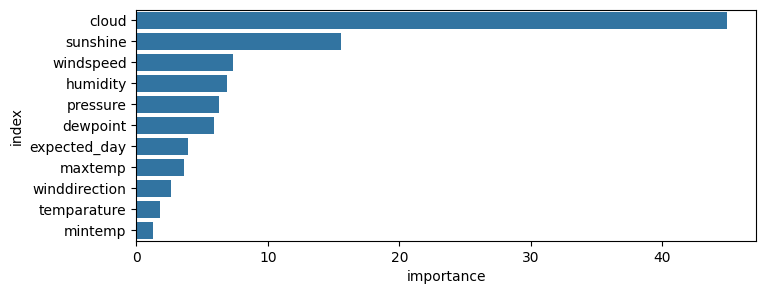

In [80]:
plt.figure(figsize=(8, 3))
sns.barplot(
    result['model_result'][0]['feature_importance'].sort_values(ascending = False).rename('importance').to_frame().reset_index(), 
    y = 'index', x = 'importance'
)
plt.show()

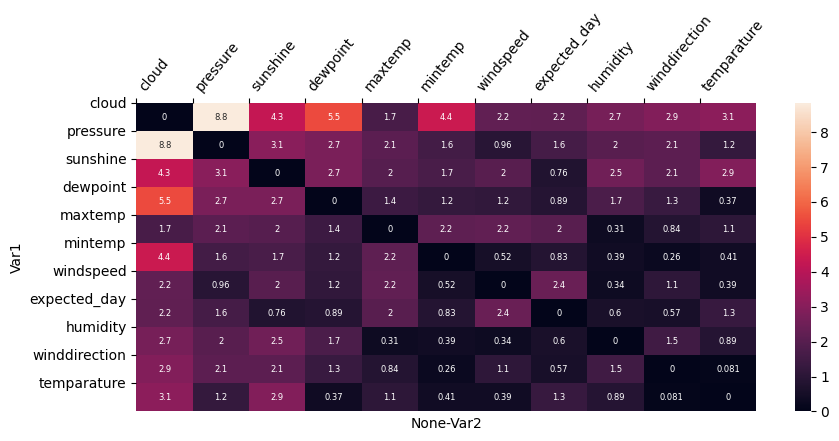

In [81]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 4))
sns.heatmap(df_cb_inter, annot=True, annot_kws = {'size': 6})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

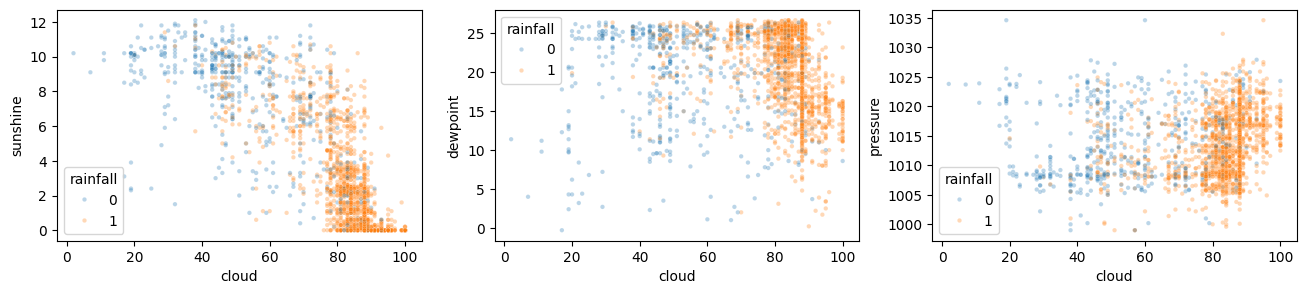

In [105]:
_, axes = plt.subplots(1, 3, figsize = (16, 3))
sns.scatterplot(
    df_train, x = 'cloud', y = 'sunshine', hue = target,  s = 10, alpha = 0.3, ax = axes[0]
)
sns.scatterplot(
    df_train, x = 'cloud', y = 'dewpoint', hue = target,  s = 10, alpha = 0.3, ax = axes[1]
)
sns.scatterplot(
    df_train, x = 'cloud', y = 'pressure', hue = target,  s = 10, alpha = 0.3, ax = axes[2]
)
plt.show()

In [83]:
result = cross_validate(
    make_pipeline(StandardScaler(), LogisticRegression()), df_train[['cloud', 'sunshine', 'dewpoint']], df_train[target], 
    scoring = 'roc_auc', cv = skf, return_train_score = True
)
np.mean(result['test_score']), np.mean(result['train_score'])

(0.8906116722783389, 0.8914101080246913)

In [84]:
hparams = {
    'model_params' : {'n_estimators': 50},
    'X_num': [i for i in X if i != 'day'] + ['expected_day']
}
result = sc.cache_result(
    'cb',
    lambda : sgml.cv(df_train, skf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]),
    rerun = 0
)
np.mean(result['valid_scores']), np.std(result['valid_scores'])

(0.8859876543209877, 0.013333097149748292)

In [111]:
df_train["chp"] = (df_train["cloud"] * df_train["humidity"]) / df_train["pressure"]
roc_auc_score(df_train[target], df_train['chp'])

0.8870454545454546

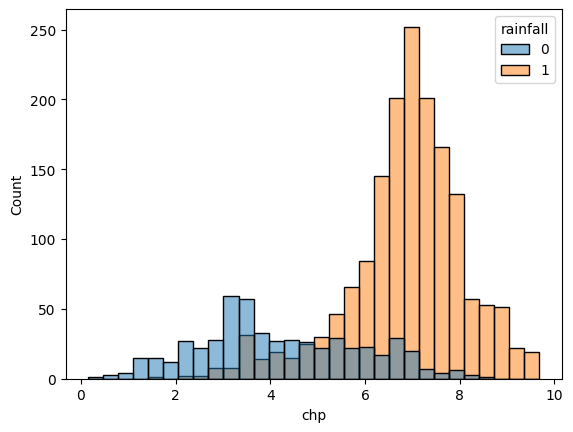

In [107]:
sns.histplot(df_train, x = df_train['chp'], hue = target)
plt.show()

In [112]:
hparams = {
    'model_params' : {'n_estimators': 50},
    'X_num': [i for i in X if i not in ['day', 'winddirection']] + ['expected_day', 'chp'],
    'lda': {'X_std': ['sunshine', 'cloud', 'dewpoint']}
}
result = sc.cache_result(
    'cb_lda',
    lambda : sgml.cv(df_train, skf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]),
    rerun = 1
)
np.mean(result['valid_scores']), np.std(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

(0.8937037037037037, 0.01427778164858055)

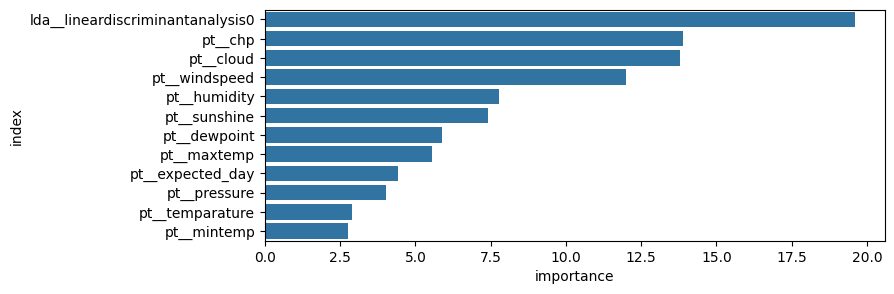

In [113]:
plt.figure(figsize=(8, 3))
sns.barplot(
    result['model_result'][0]['feature_importance'].sort_values(ascending = False).rename('importance').to_frame().reset_index(), 
    y = 'index', x = 'importance'
)
plt.show()

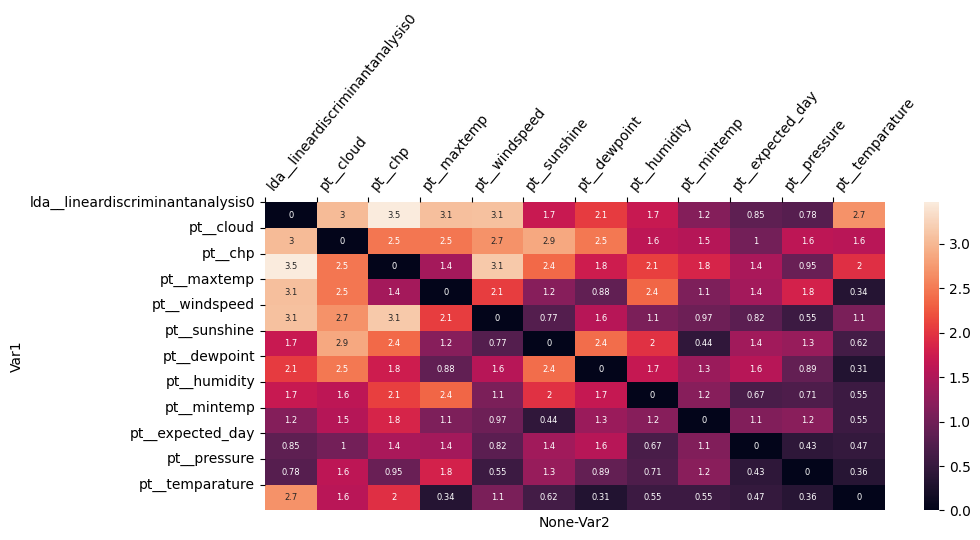

In [99]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 4))
sns.heatmap(df_cb_inter, annot=True, annot_kws = {'size': 6})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## Using Original Dataset

In [87]:
df_org['expected_day'] = df_org.index + 1

In [88]:
config2 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'train_data_proc': lambda x: pd.concat([x, df_org]),
    'y': target,
}

In [89]:
hparams = {
    'model_params' : {'n_estimators': 50},
    'X_num': [i for i in X if i != 'day'] + ['expected_day']
}
result = sc.cache_result(
    'cb2',
    lambda : sgml.cv(df_train, skf, hparams, config2, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]),
    rerun = 0
)
result['valid_scores']
np.mean(result['valid_scores']), np.std(result['valid_scores'])

(0.8898316498316499, 0.018916210610312553)

## Splitters

In [90]:
df_train2 = df_train.loc[df_train['year'] < 5]
df_test2 = df_train.loc[df_train['year'] >= 5]

In [91]:
from sklearn.model_selection import GroupKFold, TimeSeriesSplit
gkf = GroupKFold(4)
ts = TimeSeriesSplit(4)
config3 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'train_data_proc': lambda x: pd.concat([x, df_org]),
    'y': target, 'groups': 'year'
}

In [92]:
hparams = {
    'model_params' : {'n_estimators': 50},
    'X_num': [i for i in X if i != 'day'] + ['expected_day']
}
result_train = sgml.train(pd.concat([df_train2, df_org]), hparams, config2, cb_adapter)
roc_auc_score(
    df_test2[target],
    result_train[0]['model'].predict_proba(df_test2[result_train[1]])[:, 1]
)

Round:   0%|          | 0/50 [00:00<?, ?it/s]

0.8838982780442666

In [93]:
result = sc.cache_result(
    'cb_gkf',
    lambda : sgml.cv(df_train2, gkf, hparams, config3, cb_adapter),
    rerun = 0
)
np.mean(result['valid_scores']), np.std(result['valid_scores'])

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

Round:   0%|          | 0/50 [00:00<?, ?it/s]

(0.8974443845134868, 0.027040016716080032)

In [94]:
result = sc.cache_result(
    'cb_ts',
    lambda : sgml.cv(df_train2, ts, hparams, config2, cb_adapter),
    rerun = 0
)
np.mean(result['valid_scores']), np.std(result['valid_scores'])

(0.9024520224720429, 0.022162009410168715)

In [95]:
result = sc.cache_result(
    'cb_skf',
    lambda : sgml.cv(df_train2, StratifiedKFold(4), hparams, config2, cb_adapter),
    rerun = 0
)
np.mean(result['valid_scores']), np.std(result['valid_scores'])

(0.8946945786136472, 0.015140722647294583)